# Spotify Final Project
### Milestone 3: EDA and Baseline Model
### Austin Rochon, Emily Xie, and Mark Lock

In [270]:
# Import requisite packages
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

#### Run this cell to load google cloud bigquery:

In [5]:
# Set up credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="PATH"

In [6]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [7]:
%%bigquery playlist_data
WITH cte AS (
  SELECT *, 
    ROW_NUMBER() OVER(PARTITION BY track_uri ORDER BY unique_pid) AS track_row
  FROM playlist_songs.playlist_tracks_joined_rand
  LIMIT 500000
)
SELECT * 
FROM cte
WHERE track_row = 1
LIMIT 100000

#### Data cleaning

Create dataframe with song-playlist mappings (for later analysis)

In [8]:
# Copy df
playlist_mapping = playlist_data.copy()
playlist_mapping = playlist_mapping.set_index("trackid")
playlist_mapping = playlist_mapping["unique_pid"]

# Create mapping df containing trackid and list of playlists it's associated with
# https://stackoverflow.com/questions/22219004/grouping-rows-in-list-in-pandas-groupby
playlist_mapping = playlist_mapping.groupby("trackid").apply(list).reset_index(name="playlists")
playlist_mapping.head()


,trackid,playlists
0,spotify:track:000T9PNzxi3xNEucKererm,[303678]
1,spotify:track:000xQL6tZNLJzIrtIgxqSl,[17343]
2,spotify:track:000xYdQfIZ4pDmBGzQalKU,[686817]
3,spotify:track:001BVhvaZTf2icV88rU3DA,[676618]
4,spotify:track:002HVvfZx6AKPzJEeimuu5,[423684]


First fetch only numeric data

In [9]:
# Pull in only audio features 
# https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
playlist_numeric = playlist_data.select_dtypes(include=numerics)
playlist_numeric["trackid"] = playlist_data["trackid"]
playlist_numeric = playlist_numeric.set_index("trackid")
playlist_numeric = playlist_numeric.drop(["index","pid", "pos", "unique_pid", "track_row", "random"], axis=1)
playlist_numeric.head()

/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
trackid,,,,,,,,,,,,,
spotify:track:001BVhvaZTf2icV88rU3DA,0.775,0.355,6.0,-11.755,0.0,0.1580,0.061000,0.013700,0.166,0.356,87.997,205256.0,4.0
spotify:track:002HVvfZx6AKPzJEeimuu5,0.232,0.485,7.0,-13.939,0.0,0.0556,0.779000,0.934000,0.116,0.239,73.347,154573.0,4.0
spotify:track:004skCQeDn1iLntSom0rRr,0.605,0.846,9.0,-4.581,1.0,0.0778,0.000738,0.000001,0.053,0.764,132.997,177773.0,4.0
spotify:track:00CQsyWt5NGD7kaKBvG33Y,0.688,0.589,9.0,-7.276,1.0,0.1530,0.257000,0.005710,0.102,0.857,125.937,147547.0,4.0
spotify:track:00CujlY4ya5p2FNDu9BCZP,0.377,0.745,8.0,-5.059,0.0,0.0696,0.021900,0.000052,0.185,0.344,76.526,252416.0,4.0


## Modeling

#### K-means for labeling
The first thing we'll want to do is find similarities between "groups" of songs in our data set. To do so, we'll first need to construct groups, using their audio properties as features to group them by. Before we begin, we need to normalize our data.

In [10]:
def normalize(df, scalar, features):
    # Split df into features and non-features
    non_feature_df = df[df.columns.difference(features)]
    feature_df = df[features]
    
    # Scale the features
    np_transform = scalar.transform(feature_df)
    df_transform = pd.DataFrame(np_transform, columns=features)

    # Merge back the features and non-features
    non_feature_df.reset_index(drop=True, inplace=True)
    df_transform.reset_index(drop=True, inplace=True)
    df_transform = pd.concat([non_feature_df, df_transform], axis = 1)
    
    return df_transform

In [11]:
# Fit MinMaxScalar and select features we will be using (all columns from playlist_numeric)
scalar = MinMaxScaler().fit(playlist_numeric)
features = playlist_numeric.columns

# Normalize data
playlist_norm = normalize(playlist_numeric, scalar, features)
playlist_norm["trackid"] = playlist_numeric.index
playlist_norm = playlist_norm.set_index("trackid")

# Drop NAs
display(playlist_norm.shape)
playlist_norm = playlist_norm.dropna(how="any")
display(playlist_norm.shape)

display(playlist_numeric.head())
display(playlist_norm.head())

(100000, 13)

(99710, 13)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
trackid,,,,,,,,,,,,,
spotify:track:001BVhvaZTf2icV88rU3DA,0.775,0.355,6.0,-11.755,0.0,0.1580,0.061000,0.013700,0.166,0.356,87.997,205256.0,4.0
spotify:track:002HVvfZx6AKPzJEeimuu5,0.232,0.485,7.0,-13.939,0.0,0.0556,0.779000,0.934000,0.116,0.239,73.347,154573.0,4.0
spotify:track:004skCQeDn1iLntSom0rRr,0.605,0.846,9.0,-4.581,1.0,0.0778,0.000738,0.000001,0.053,0.764,132.997,177773.0,4.0
spotify:track:00CQsyWt5NGD7kaKBvG33Y,0.688,0.589,9.0,-7.276,1.0,0.1530,0.257000,0.005710,0.102,0.857,125.937,147547.0,4.0
spotify:track:00CujlY4ya5p2FNDu9BCZP,0.377,0.745,8.0,-5.059,0.0,0.0696,0.021900,0.000052,0.185,0.344,76.526,252416.0,4.0


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
trackid,,,,,,,,,,,,,
spotify:track:001BVhvaZTf2icV88rU3DA,0.784413,0.355,0.545455,0.768649,0.0,0.163900,0.061245,0.013700,0.166,0.356,0.354741,0.043233,0.8
spotify:track:002HVvfZx6AKPzJEeimuu5,0.234818,0.485,0.636364,0.733853,0.0,0.057676,0.782129,0.934000,0.116,0.239,0.295682,0.032397,0.8
spotify:track:004skCQeDn1iLntSom0rRr,0.612348,0.846,0.818182,0.882946,1.0,0.080705,0.000741,0.000001,0.053,0.764,0.536149,0.037357,0.8
spotify:track:00CQsyWt5NGD7kaKBvG33Y,0.696356,0.589,0.818182,0.840009,1.0,0.158714,0.258032,0.005710,0.102,0.857,0.507688,0.030894,0.8
spotify:track:00CujlY4ya5p2FNDu9BCZP,0.381579,0.745,0.727273,0.875331,0.0,0.072199,0.021988,0.000052,0.185,0.344,0.308498,0.053317,0.8


#### Run k-means with chosen number of clusters (12)
The code below runs k-means clustering, assigns cluster labels, and outputs 1) our raw data with cluster assignments, and 2) mean data for each cluster

In [12]:
def kmeans(num_clusters, data):
    '''Runs kmeans algorithm, returning cluster assignment and centers'''
    # Initialize KMeans
    kmeans = KMeans(n_clusters=num_clusters)

    # Fitting with inputs
    kmeans = kmeans.fit(data)

    # Predicting clusters
    labels = kmeans.predict(data)

    # Get cluster centers
    centers = kmeans.cluster_centers_
    
    return labels, centers


def build_kmeans_output(data, col_name):
    '''Builds out final dataset'''
    df_means[col_name] = data.groupby(['cluster'])[col_name].mean().to_frame(col_name)    
    
    
def run_kmeans(df, clusters):
    # Run kmeans, given a specified number of clusters
    data = df.copy()
    labels, centers = kmeans(clusters, data.drop("trackid", axis=1))
    data['cluster'] = labels
    
    # Build df_means table to store results
    df_means = data.groupby(['cluster'])['trackid'].count().to_frame('n')
    
    for col in data.columns.values:
        if col != 'trackid':
            df_means[col] = data.groupby(['cluster'])[col].mean().to_frame(col)    
      
    # Generate alphabetical representation of clusters
    mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6: 'G', 7:'H', 8:'I', 9:'J', 10:"K", 11:"L"}
    df_means['cluster_alpha'] = df_means['cluster']
    df_means = df_means.replace({'cluster_alpha':mapping})

    data['cluster_alpha'] = data['cluster']
    data = data.replace({'cluster_alpha':mapping})
    
    return df_means, data    

In [13]:
k = 12
playlist_norm["trackid"] = playlist_norm.index
playlist_means, playlist_clusters = run_kmeans(playlist_norm, k)
playlist_means

,n,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster,cluster_alpha
cluster,,,,,,,,,,,,,,,,
0,9921,0.673501,0.733242,0.124923,0.850971,1.0,0.103688,0.173493,0.017766,0.201296,0.736067,0.495171,0.046717,0.792803,0,A
1,10271,0.532921,0.708741,0.132376,0.853756,1.0,0.092156,0.089337,0.023058,0.227768,0.326965,0.508174,0.052299,0.788200,1,B
2,12305,0.642654,0.719278,0.830764,0.850848,0.0,0.122460,0.144707,0.022993,0.210004,0.551692,0.492036,0.050323,0.794067,2,C
3,11379,0.521121,0.721368,0.720098,0.854944,1.0,0.088842,0.086353,0.023970,0.229279,0.347172,0.507880,0.051696,0.788452,3,D
4,5398,0.459254,0.300409,0.504126,0.731035,0.0,0.070208,0.800265,0.298768,0.168817,0.289242,0.449339,0.051365,0.756206,4,E
5,3468,0.593388,0.700279,0.565272,0.821950,0.0,0.068527,0.126662,0.757900,0.196823,0.400799,0.502191,0.059779,0.788120,5,F
6,4268,0.568529,0.715319,0.430476,0.824461,1.0,0.067967,0.108123,0.772308,0.193737,0.413500,0.503547,0.058342,0.788285,6,G
7,7582,0.526284,0.369839,0.730654,0.780992,1.0,0.075838,0.712843,0.024284,0.192324,0.394949,0.463130,0.047868,0.761435,7,H
8,7457,0.504635,0.341875,0.179124,0.774958,1.0,0.070596,0.738935,0.024250,0.185118,0.349706,0.462141,0.048914,0.761352,8,I


#### Visualize attributes across clusters

In [14]:
def plot_bar_by_cluster(df, cols):
    sns.set(style="whitegrid")

    # Draw a nested barplot 
    chart = sns.catplot(x=cols[0], y=cols[1], data=df[cols],
                    height=6, kind="bar", palette="Blues_r")
    chart.despine(left=True)
    chart.set_ylabels(cols[1])
    chart.set_xlabels(cols[0])
    if cols[1] == "n":
        plt.title(f"""{cols[1]} by cluster""", pad=0); 
    else:
        plt.title(f"""Mean {cols[1]} by cluster""", pad=0); 
        
    plt.savefig(f"../out/{cols[1]}_cluster_comparison.svg", dpi=1200)

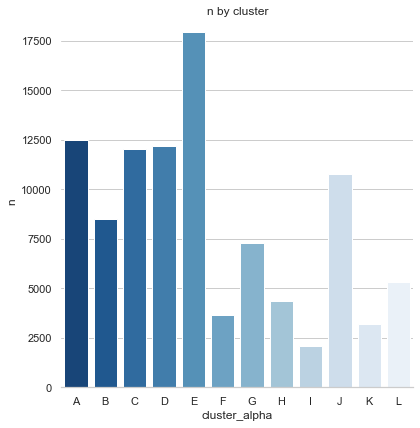

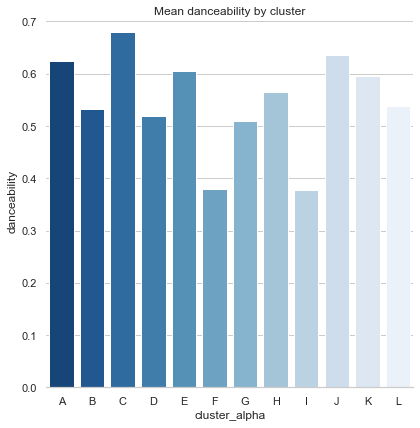

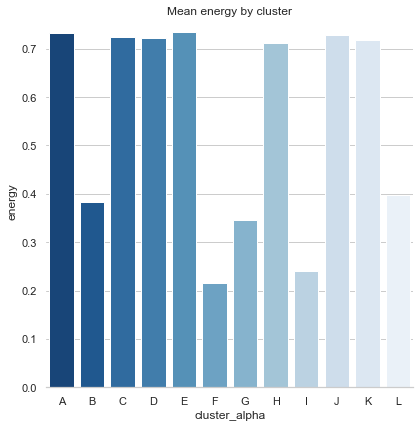

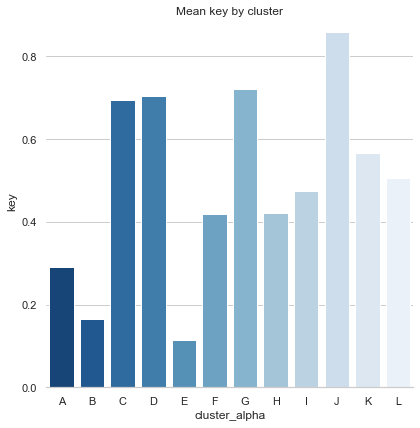

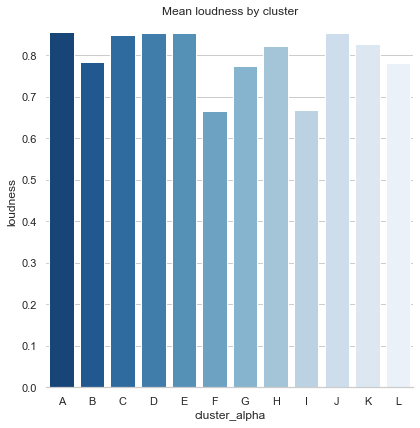

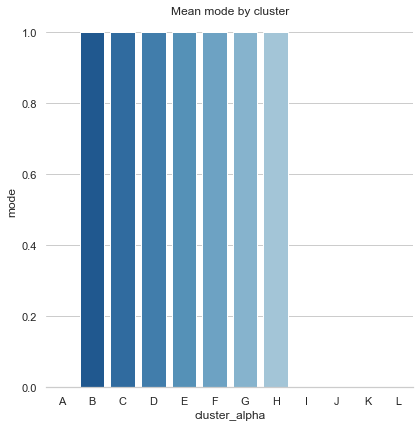

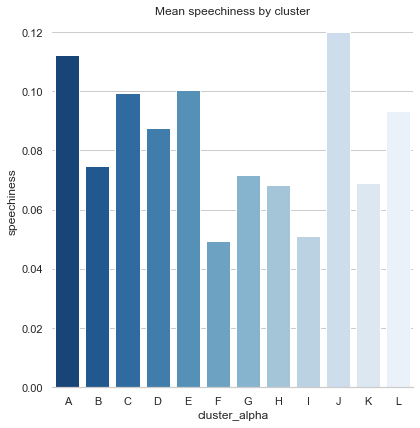

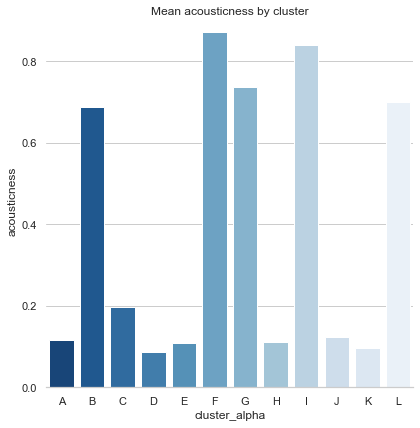

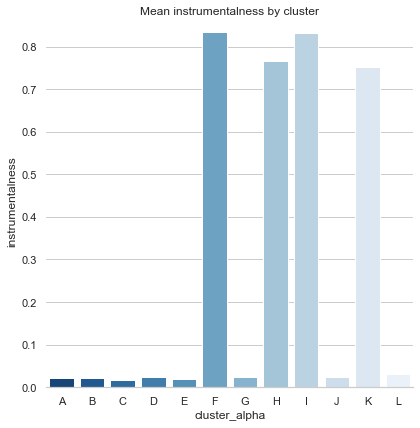

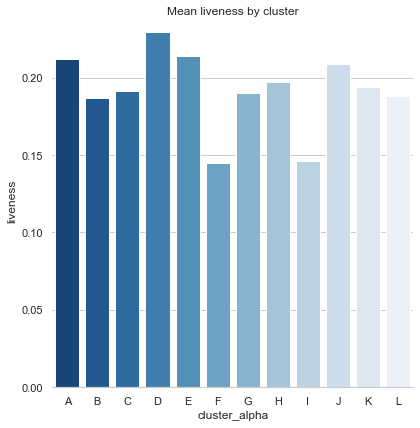

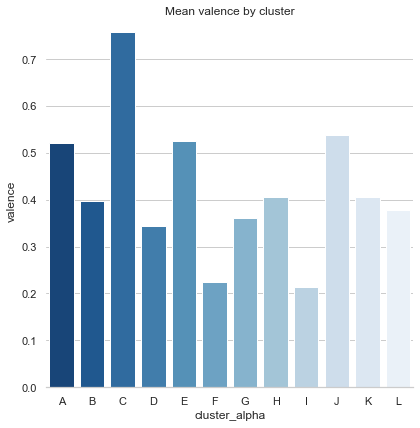

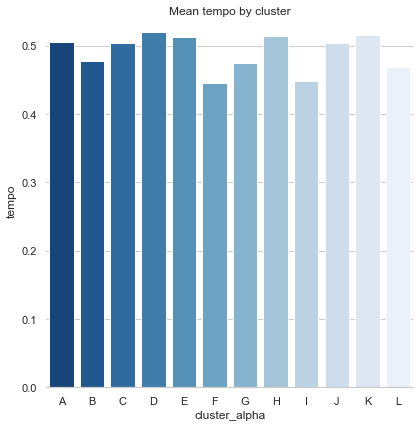

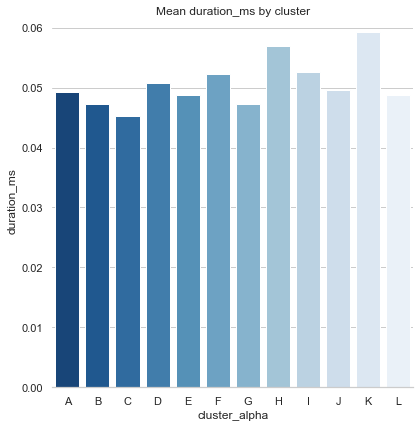

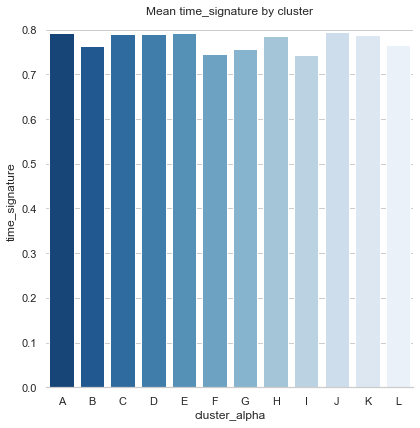

In [105]:
features = ['n','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
           'duration_ms', 'time_signature']

for feature in features:
    cols = ["cluster_alpha"]
    cols.append(feature)
    plot_bar_by_cluster(playlist_means, cols)

#### K-Nearest Neighbors
Now that we have labels for our tracks (cluster number), we can build a recommender engine. Let's use K-Nearest neighbors to fit future songs to a given cluster. First, we need to split our data into train and test.

In [15]:
playlist_clusters = playlist_clusters.drop(["trackid", "cluster_alpha"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(playlist_clusters.loc[:, playlist_clusters.columns != 'cluster'], 
                                                    playlist_clusters.cluster, test_size=0.2, 
                                                    random_state = 666, 
                                                    stratify = playlist_clusters.cluster)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((79768, 13), (19942, 13), (79768,), (19942,))

Next we will fit our kNN model to our chosen k (100)

In [16]:
neighbors = 100
knn_chosen = KNeighborsClassifier(n_neighbors=neighbors).fit(X_train, y_train)
knn_chosen_predictions_train = knn_chosen.predict(X_train)
knn_chosen_predictions_test = knn_chosen.predict(X_test)

#### Make Predictions With K-Nearest Neighbors
Now that we have a model, selected using cross-validation, we can predict class labels. Can we also get the most similar song? The below returns a list of the *n* closest songs in terms of feature vector distance

In [17]:
def generate_nearest_songs(trackid, features):
    
    mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6: 'G', 7:'H', 8:'I', 9:'J', 10: 'K', 11: 'L'}
    
    # Generate n closest neighbors
    feature_vector = features.loc[trackid].drop("cluster").to_numpy().reshape(1,-1)
    kneighbors = knn_chosen.kneighbors(feature_vector)
    kneighbors_indices = kneighbors[1].reshape(-1)
    kneighbors_distances = kneighbors[0].reshape(-1)
    
    # Predict cluster
    predicted_cluster = mapping[knn_chosen.predict(feature_vector)[0]]

    # Save distances to df
    distances = pd.DataFrame({"trackid": X_train.iloc[kneighbors_indices].index, "distance": kneighbors_distances})

    # Get their playlist data
    p_df = playlist_data.set_index("trackid").loc[X_train.iloc[kneighbors_indices].index]\
        [["artist_name", "track_name"]]

    # Join distances and track data
    return predicted_cluster, p_df.merge(distances, how="inner", on="trackid")


def plot_nearest_neighbors(neighbors_df, artist_track):
    plot_df = neighbors_df[["artist_track", "distance"]]
    # truncation: https://stackoverflow.com/questions/22792740/truncating-column-width-in-pandas
    plot_df["artist_track"] = plot_df["artist_track"].str[:50]
    fig, ax = plt.subplots()
    ax = sns.barplot(x='distance', y='artist_track', data=plot_df, palette="Blues_d")
    ax.set_xlabel('distance')
    plt.title(artist_track)
    
    filename = artist_track.replace(" ", "").replace(":", "_")
    plt.tight_layout()
    plt.savefig(f"../out/{filename}_nearestneighbors.svg", quality=95, dpi=1200)
    

In [18]:
clusters = []

# Wolfgang Amadeus Mozart, Piano Concerto No.21 in C Major,: "spotify:track:3aX8Xg1XxtEplBZDORWmyv"
cluster, neighbors = generate_nearest_songs("spotify:track:3aX8Xg1XxtEplBZDORWmyv", playlist_clusters)
artist_track = "Mozart: Piano Concerto No.21 in C Major"
neighbors["artist_track"] = neighbors["artist_name"] + ": " + neighbors["track_name"]
clusters.append({"artist_track": artist_track, "cluster": cluster})
plot_nearest_neighbors(neighbors.head(10), artist_track)

# Kendrick Lamar, alright: "spotify:track:3iVcZ5G6tvkXZkZKlMpIUs"
cluster, neighbors = generate_nearest_songs("spotify:track:0ECs7wpW9157Tk5yBUGbE0", playlist_clusters)
artist_track = "Kendrick Lamar: alright"
neighbors["artist_track"] = neighbors["artist_name"] + ": " + neighbors["track_name"]
clusters.append({"artist_track": artist_track, "cluster": cluster})
plot_nearest_neighbors(neighbors.head(10), artist_track)

# Slayer, Raining Blood: "spotify:track:4Yx9Tw9dTgQ8eGCq3PRDyn"
cluster, neighbors = generate_nearest_songs("spotify:track:4Yx9Tw9dTgQ8eGCq3PRDyn", playlist_clusters)
artist_track = "Slayer: Raining Blood"
neighbors["artist_track"] = neighbors["artist_name"] + ": " + neighbors["track_name"]
clusters.append({"artist_track": artist_track, "cluster": cluster})
plot_nearest_neighbors(neighbors.head(10), artist_track)

pd.DataFrame(clusters)

KeyError: 'spotify:track:3aX8Xg1XxtEplBZDORWmyv'

#### Code for examples

Fetch trackIDs for a given artist / track

In [19]:
tester = X_train.merge(playlist_data.set_index("trackid"), how="inner", on="trackid")
# tester[tester["artist_name"] == "Lady Gaga"][["artist_name", "track_name"]]
tester[tester["track_name"] == "Bad Romance"][["artist_name", "track_name"]]


,artist_name,track_name
trackid,,
spotify:track:5xrHvVmSF3ui0EKI8FArv3,Scott Bradlee's Postmodern Jukebox,Bad Romance
spotify:track:0n3sHHfdOq6Awix3JPe3xl,Halestorm,Bad Romance
spotify:track:3vYhrG4O1NqVBSc7oXXpQH,Lissie,Bad Romance
spotify:track:5P5cGNzqh6A353N3ShDK6Y,Lady Gaga,Bad Romance


For a given song, fetch all songs within same cluster, along with their playlists and features

In [403]:
# Lady Gaga: Bad Romance
# spotify:track:5P5cGNzqh6A353N3ShDK6Y
gaga_cluster, gaga_neighbors = generate_nearest_songs("spotify:track:5P5cGNzqh6A353N3ShDK6Y", playlist_clusters.drop("cluster_alpha", axis=1))

In [404]:
# Add cluster_alpha back
mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6: 'G', 7:'H', 8:'I', 9:'J', 10: 'K', 11: 'L'}
playlist_clusters["cluster_alpha"] = playlist_clusters["cluster"]
playlist_clusters = playlist_clusters.replace({'cluster_alpha':mapping})
playlist_clusters.head()

# Grab all associated with gaga_cluster
playlist_gaga = playlist_clusters[playlist_clusters["cluster_alpha"] == gaga_cluster]

In [405]:
# Join to playlist data
playlist_gaga = playlist_gaga.merge(playlist_mapping, how="inner", on="trackid")

# Join to track data
playlist_gaga = playlist_gaga.merge(playlist_data[["artist_name", "track_name", "trackid"]], 
                                    how="inner", on="trackid")

# playlist_gaga.to_csv("../out/gaga_cluster.csv")
playlist_gaga.head()


# # playlist_data.merge(playlist_mapping, how="inner", on="trackid")
# playlist_gaga.merge(playlist_data, how="inner", on="trackid")

,trackid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster,cluster_alpha,playlists,artist_name,track_name
0,spotify:track:00OVN9m036NqWcABlCXFpE,0.883603,0.520,0.181818,0.838448,1.0,0.134855,0.051104,0.010100,0.0901,0.582,0.397239,0.056358,0.8,0,A,[305773],Vanessa Williams,Happiness
1,spotify:track:01HCxML9FEN3NEsVfSiCa0,0.703441,0.912,0.181818,0.914524,1.0,0.354772,0.047490,0.000000,0.6060,0.583,0.343070,0.037967,0.8,0,A,[194953],G-Unit,Salute U
2,spotify:track:01MtUZOoNYzkIU6FeQGDdR,0.783401,0.726,0.090909,0.857980,1.0,0.127593,0.180723,0.000001,0.3190,0.743,0.411199,0.054083,0.8,0,A,[229939],Natasha Bedingfield,Drop Me In The Middle
3,spotify:track:01NRpu9CeEx4DqiDjG20PA,0.619433,0.649,0.181818,0.842797,1.0,0.032365,0.552209,0.000862,0.0858,0.613,0.395021,0.050816,0.8,0,A,[548349],Greensky Bluegrass,Miss September
4,spotify:track:01YSGdA81SstXR0QAwKQxF,0.617409,0.932,0.000000,0.900647,1.0,0.218880,0.202811,0.000000,0.1960,0.862,0.436850,0.202182,0.8,0,A,[478734],Grand Maître Franco,Lettre à M. le DG


### Monte Carlo playlist selection

Using Lady Gaga's Bad Romance as an example, let's examine how we would apply Monte-Carlo to playlist selection, first naively, then weighted by inverse distance.

In [406]:
def select_top_n_playlists_naive(df, n=1000):
    # Instantiate empty dict with playlist counts
    playlist_counts = {playlist[0]: 0 for playlist in df["playlists"]}
    
    # For each iteration in our specified n, count the randomly selected playlist
    for i in range(n):
        indices = np.arange(df.shape[0])
        ind = np.random.choice(indices)
        playlist_counts[df.iloc[ind]["playlists"][0]] += 1
        
    # Sort by count
    # https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    playlist_counts = {str(k): v for k, v in sorted(playlist_counts.items(), key=lambda item: item[1], reverse=True)[:10]}

    return playlist_counts

In [407]:
def plot_top_n_playlists(playlist_dict, sim_type="Naive"):
    # Build dataframe and sort by count
    df =  pd.DataFrame({"playlist": list(playlist_dict.keys()),
                        "count": list(playlist_dict.values())})
    df = df.sort_values("count", ascending=False)
    
    ax = sns.barplot(x="count", 
                 y="playlist",
                 data=df,
                 palette="Blues_r", 
                 orient="h",
                 order=df["playlist"]).set_title(f"Top Playlists Song Assigned To: {sim_type} Monte Carlo")
    plt.savefig(f"../out/top10_playlists_montecarlo_{sim_type}.svg", dpi=1200);
    
    

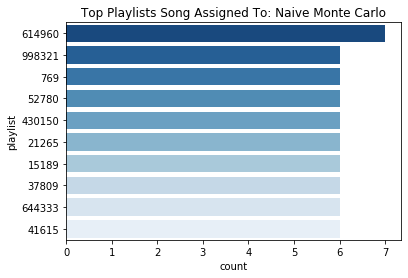

In [409]:
# Generate top 10 playlists
top_playlists_naive = select_top_n_playlists_naive(playlist_gaga, n=10000)

# Plot em
plot_top_n_playlists(top_playlists_naive, sim_type="Naive")

Next, we will weigh the playlists by inverse distance

In [410]:
def select_top_n_playlists_by_distance(df, features, trackid="spotify:track:5P5cGNzqh6A353N3ShDK6Y", n=1000):
    # Instantiate empty dict with playlist counts and empty distance array
    playlist_counts = {playlist[0]: 0 for playlist in df["playlists"]}
    distances = []
    inverse_distances = []
    
    # Compute euclidean distance from target track for each row
    gaga_feature_vector = df.set_index("trackid").loc[trackid][features].to_numpy().reshape(1,-1)
    
    for idx in range(df.shape[0]):
        target_feature_vector = df.iloc[idx][features].to_numpy().reshape(1,-1)
        distances.append(distance.euclidean(gaga_feature_vector, target_feature_vector))
        inverse_distances.append(1 / (1 + distance.euclidean(gaga_feature_vector, target_feature_vector)))
        
    # Now, get probabilities to sum to 1
    inverse_distances /= sum(inverse_distances)
        
    # Add distances as column to original df
    df["distance"] = distances    
    df["inverse_distance"] = inverse_distances
    
    # For each iteration in our specified n, count the selected playlist, this time using inverse distance
    for i in range(n):
        indices = np.arange(df.shape[0])
        idx = np.random.choice(indices, p=inverse_distances)
        playlist_counts[df.iloc[idx]["playlists"][0]] += 1
    
    # Sort by count
    # https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    playlist_counts = {str(k): v for k, v in sorted(playlist_counts.items(), key=lambda item: item[1], reverse=True)[:10]}

    return playlist_counts

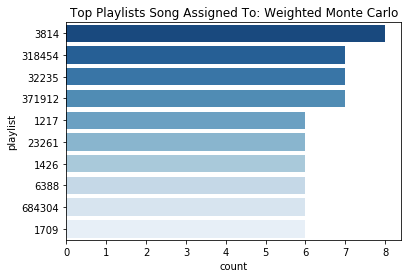

In [364]:
features = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness",
            "liveness", "valence", "tempo", "duration_ms", "time_signature"]

# Generate top n playlists
top_playlists_weighted = select_top_n_playlists_by_distance(playlist_gaga, features, n=10000)

# Plot em
plot_top_n_playlists(top_playlists_weighted, sim_type="Weighted")

In [411]:
# Okay, strip out these annoying lists of playlists
playlist_gaga_working = playlist_gaga.copy()
playlist_gaga_working["playlists"] = playlist_gaga_working["playlists"].apply(lambda x: x[0])

playlist_gaga_working["playlists"]

0       305773
1       194953
2       229939
3       548349
4       478734
         ...  
9916      4254
9917    501880
9918    127185
9919    374524
9920    363386
Name: playlists, Length: 9921, dtype: int64

In [412]:
# Create features df with mean values
playlist_features = playlist_gaga_working.groupby("playlists").agg({"danceability": "mean", 
                                                            "energy": "mean",
                                                            "key": "mean", 
                                                            "loudness": "mean", 
                                                            "mode": "mean", 
                                                            "speechiness": "mean",
                                                            "acousticness": "mean", 
                                                            "instrumentalness": "mean",
                                                            "liveness":"mean", 
                                                            "valence": "mean", 
                                                            "tempo": "mean", 
                                                            "duration_ms": "mean", 
                                                            "time_signature": "mean"})

playlist_features.head()
    

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
playlists,,,,,,,,,,,,,
33,0.502024,0.856,0.181818,0.892426,1.0,0.052905,0.186747,0.000047,0.3560,0.592,0.332593,0.045283,0.8
39,0.563765,0.737,0.272727,0.864321,1.0,0.049378,0.014257,0.000000,0.3140,0.817,0.637144,0.043005,0.8
53,0.862348,0.693,0.090909,0.846477,1.0,0.284232,0.024096,0.000000,0.1100,0.660,0.386870,0.049334,0.8
59,0.709514,0.864,0.272727,0.886611,1.0,0.065456,0.003323,0.000000,0.0421,0.811,0.427453,0.041896,0.8
64,0.421053,0.803,0.181818,0.876541,1.0,0.097303,0.000152,0.000270,0.2030,0.645,0.804535,0.031527,0.8


In [432]:
# Get top playlists for each
top_playlist_naive = int(max(top_playlists_naive, key=top_playlists_naive.get))
top_playlist_weighted = int(max(top_playlists_weighted, key=top_playlists_weighted.get))

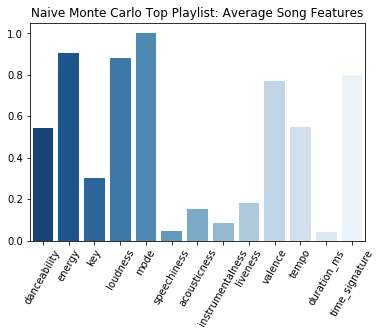

In [447]:
# Plot
naive = sns.barplot(data=playlist_features[playlist_features.index == top_playlist_naive], palette="Blues_r")
naive.set_title("Naive Monte Carlo Top Playlist: Average Song Features")

for item in naive.get_xticklabels():
    item.set_rotation(60)
    
plt.savefig(f"../out/top_playlist_song_features_naive.svg", dpi=1200)    

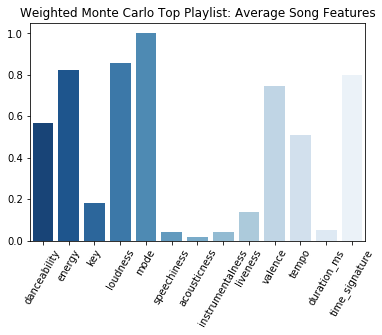

In [446]:
# Plot
weighted = sns.barplot(data=playlist_features[playlist_features.index == top_playlist_weighted], palette="Blues_r")
weighted.set_title("Weighted Monte Carlo Top Playlist: Average Song Features")

for lab in weighted.get_xticklabels():
    lab.set_rotation(60)
    
plt.savefig(f"../out/top_playlist_song_features_weighted.svg", dpi=1200)    

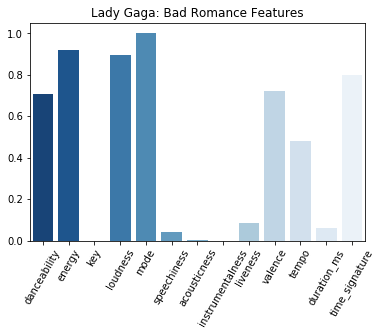

In [448]:
gaga = sns.barplot(data=playlist_gaga[playlist_gaga["trackid"] == "spotify:track:5P5cGNzqh6A353N3ShDK6Y"][features],
                  palette="Blues_r")
gaga.set_title("Lady Gaga: Bad Romance Features")

for item in gaga.get_xticklabels():
    item.set_rotation(60)
    
plt.savefig(f"../out/top_playlist_song_features_gaga.svg", dpi=1200)    

